In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import joblib
import warnings
import time
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('walmart_cleaned.csv')
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Quarter',
       'IsWeekend', 'Log_Weekly_Sales', 'WeekOfYear'],
      dtype='object')

In [3]:
y = df['Weekly_Sales'].copy()
X = df.drop(columns=['Weekly_Sales','Date','Log_Weekly_Sales'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
CV_FOLDS = 5  
scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error'
}
results = {}
def evaluate_model_with_cv(model, X_train, X_test, y_train, y_test, model_name, cv=5):
    start_time = time.time()
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    cv_mse_scores = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse_scores = np.sqrt(cv_mse_scores)
    cv_mae_scores = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    # Final model predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    training_time = time.time() - start_time
    metrics = {
        'Model': model_name,
        'CV_R2_Mean': cv_r2_scores.mean(),
        'CV_R2_Std': cv_r2_scores.std(),
        'CV_RMSE_Mean': cv_rmse_scores.mean(),
        'CV_RMSE_Std': cv_rmse_scores.std(),
        'CV_MAE_Mean': cv_mae_scores.mean(),
        'CV_MAE_Std': cv_mae_scores.std(),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Test_MAPE': np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100,
        'Training_Time': training_time,
        'Overfitting': abs(cv_r2_scores.mean() - r2_score(y_test, y_test_pred))
    }
    
    return metrics, y_test_pred, cv_r2_scores


In [7]:
# MODEL 1: LINEAR REGRESSION (Simple)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

lr_metrics, lr_pred, lr_cv_scores = evaluate_model_with_cv(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 
    'Linear Regression', cv=CV_FOLDS
)
results['Linear Regression'] = {
    'model': lr_model,
    'metrics': lr_metrics,
    'predictions': lr_pred,
    'cv_scores': lr_cv_scores,
    'best_params': 'No hyperparameters'
}


In [8]:
# MODEL 2: RIDGE REGRESSION (L2 Regularization)
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000]
}
ridge_grid = GridSearchCV(
    Ridge(), ridge_params, cv=CV_FOLDS, scoring='r2', n_jobs=-1, verbose=1,
    return_train_score=True
)
ridge_grid.fit(X_train_scaled, y_train)

ridge_metrics, ridge_pred, ridge_cv_scores = evaluate_model_with_cv(
    ridge_grid.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test,
    'Ridge Regression', cv=CV_FOLDS
)
results['Ridge Regression'] = {
    'model': ridge_grid.best_estimator_,
    'metrics': ridge_metrics,
    'predictions': ridge_pred,
    'cv_scores': ridge_cv_scores,
    'best_params': ridge_grid.best_params_,
    'grid_results': ridge_grid.cv_results_
}

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [9]:
# MODEL 3: LASSO REGRESSION (L1 Regularization)
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000],
    'max_iter': [5000]
}
lasso_grid = GridSearchCV(
    Lasso(random_state=42), lasso_params, cv=CV_FOLDS, scoring='r2', n_jobs=-1, verbose=1,
    return_train_score=True
)
lasso_grid.fit(X_train_scaled, y_train)

lasso_metrics, lasso_pred, lasso_cv_scores = evaluate_model_with_cv(
    lasso_grid.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test,
    'Lasso Regression', cv=CV_FOLDS
)
results['Lasso Regression'] = {
    'model': lasso_grid.best_estimator_,
    'metrics': lasso_metrics,
    'predictions': lasso_pred,
    'cv_scores': lasso_cv_scores,
    'best_params': lasso_grid.best_params_,
    'grid_results': lasso_grid.cv_results_
}

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [10]:
# MODEL 4: ELASTIC NET (L1 + L2 Regularization)
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # Mix of L1 and L2
    'max_iter': [5000]
}
elastic_grid = GridSearchCV(
    ElasticNet(random_state=42), elastic_params, cv=CV_FOLDS, scoring='r2', n_jobs=-1, verbose=1,
    return_train_score=True
)
elastic_grid.fit(X_train_scaled, y_train)

elastic_metrics, elastic_pred, elastic_cv_scores = evaluate_model_with_cv(
    elastic_grid.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test,
    'Elastic Net', cv=CV_FOLDS
)
results['Elastic Net'] = {
    'model': elastic_grid.best_estimator_,
    'metrics': elastic_metrics,
    'predictions': elastic_pred,
    'cv_scores': elastic_cv_scores,
    'best_params': elastic_grid.best_params_,
    'grid_results': elastic_grid.cv_results_
}

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [11]:
# MODEL 5: POLYNOMIAL REGRESSION (degree=2)
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

poly_params = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

poly_grid = GridSearchCV(
    poly_pipeline, poly_params, cv=CV_FOLDS, scoring='r2', n_jobs=-1, verbose=1,
    return_train_score=True
)
poly_grid.fit(X_train, y_train)
y_train_pred_poly = poly_grid.predict(X_train)
y_test_pred_poly = poly_grid.predict(X_test)


cv_r2_poly = cross_val_score(poly_grid.best_estimator_, X_train, y_train, cv=CV_FOLDS, scoring='r2', n_jobs=-1)
cv_mse_poly = -cross_val_score(poly_grid.best_estimator_, X_train, y_train, cv=CV_FOLDS, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_poly = np.sqrt(cv_mse_poly)

poly_metrics = {
    'Model': 'Polynomial (deg=2)',
    'CV_R2_Mean': cv_r2_poly.mean(),
    'CV_R2_Std': cv_r2_poly.std(),
    'CV_RMSE_Mean': cv_rmse_poly.mean(),
    'CV_RMSE_Std': cv_rmse_poly.std(),
    'CV_MAE_Mean': 0,  # Not calculated for speed
    'CV_MAE_Std': 0,
    'Train_R2': r2_score(y_train, y_train_pred_poly),
    'Test_R2': r2_score(y_test, y_test_pred_poly),
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_poly)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_poly)),
    'Train_MAE': mean_absolute_error(y_train, y_train_pred_poly),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred_poly),
    'Test_MAPE': np.mean(np.abs((y_test - y_test_pred_poly) / y_test)) * 100,
    'Training_Time': 0,
    'Overfitting': abs(cv_r2_poly.mean() - r2_score(y_test, y_test_pred_poly))
}

results['Polynomial (deg=2)'] = {
    'model': poly_grid.best_estimator_,
    'metrics': poly_metrics,
    'predictions': y_test_pred_poly,
    'cv_scores': cv_r2_poly,
    'best_params': poly_grid.best_params_,
    'grid_results': poly_grid.cv_results_
}

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [12]:
# MODEL 6: POLYNOMIAL REGRESSION (degree=3)
poly3_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

poly3_params = {
    'regressor__alpha': [0.1, 1, 10, 100, 1000, 5000]
}

poly3_grid = GridSearchCV(
    poly3_pipeline, poly3_params, cv=CV_FOLDS, scoring='r2', n_jobs=-1, verbose=1,
    return_train_score=True
)
poly3_grid.fit(X_train, y_train)

y_train_pred_poly3 = poly3_grid.predict(X_train)
y_test_pred_poly3 = poly3_grid.predict(X_test)

cv_r2_poly3 = cross_val_score(poly3_grid.best_estimator_, X_train, y_train, cv=CV_FOLDS, scoring='r2', n_jobs=-1)
cv_mse_poly3 = -cross_val_score(poly3_grid.best_estimator_, X_train, y_train, cv=CV_FOLDS, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_poly3 = np.sqrt(cv_mse_poly3)

poly3_metrics = {
    'Model': 'Polynomial (deg=3)',
    'CV_R2_Mean': cv_r2_poly3.mean(),
    'CV_R2_Std': cv_r2_poly3.std(),
    'CV_RMSE_Mean': cv_rmse_poly3.mean(),
    'CV_RMSE_Std': cv_rmse_poly3.std(),
    'CV_MAE_Mean': 0,
    'CV_MAE_Std': 0,
    'Train_R2': r2_score(y_train, y_train_pred_poly3),
    'Test_R2': r2_score(y_test, y_test_pred_poly3),
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_poly3)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_poly3)),
    'Train_MAE': mean_absolute_error(y_train, y_train_pred_poly3),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred_poly3),
    'Test_MAPE': np.mean(np.abs((y_test - y_test_pred_poly3) / y_test)) * 100,
    'Training_Time': 0,
    'Overfitting': abs(cv_r2_poly3.mean() - r2_score(y_test, y_test_pred_poly3))
}

results['Polynomial (deg=3)'] = {
    'model': poly3_grid.best_estimator_,
    'metrics': poly3_metrics,
    'predictions': y_test_pred_poly3,
    'cv_scores': cv_r2_poly3,
    'best_params': poly3_grid.best_params_,
    'grid_results': poly3_grid.cv_results_
}


Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [13]:
# MODEL 7: LINEAR SVR
linear_svr_params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [3000]
}

linear_svr_grid = GridSearchCV(
    LinearSVR(random_state=42, dual='auto'), 
    linear_svr_params, 
    cv=CV_FOLDS,
    scoring='r2', 
    n_jobs=-1, 
    verbose=1,
    return_train_score=True
)
linear_svr_grid.fit(X_train_scaled, y_train)

linear_svr_metrics, linear_svr_pred, linear_svr_cv_scores = evaluate_model_with_cv(
    linear_svr_grid.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test,
    'Linear SVR', cv=CV_FOLDS
)
results['Linear SVR'] = {
    'model': linear_svr_grid.best_estimator_,
    'metrics': linear_svr_metrics,
    'predictions': linear_svr_pred,
    'cv_scores': linear_svr_cv_scores,
    'best_params': linear_svr_grid.best_params_,
    'grid_results': linear_svr_grid.cv_results_
}

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [14]:
# MODEL 8: SVR (kernel='linear')
svr_linear_params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
    'kernel': ['linear']
}

svr_linear_grid = GridSearchCV(
    SVR(), 
    svr_linear_params, 
    cv=CV_FOLDS,
    scoring='r2', 
    n_jobs=-1, 
    verbose=1,
    return_train_score=True
)
svr_linear_grid.fit(X_train_scaled, y_train)

svr_linear_metrics, svr_linear_pred, svr_linear_cv_scores = evaluate_model_with_cv(
    svr_linear_grid.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test,
    'SVR (linear)', cv=CV_FOLDS
)
results['SVR (linear)'] = {
    'model': svr_linear_grid.best_estimator_,
    'metrics': svr_linear_metrics,
    'predictions': svr_linear_pred,
    'cv_scores': svr_linear_cv_scores,
    'best_params': svr_linear_grid.best_params_,
    'grid_results': svr_linear_grid.cv_results_
}

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [15]:
# MODEL 9: KNN REGRESSION
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20, 25, 30, 40, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'p': [1, 2]
}

knn_grid = GridSearchCV(
    KNeighborsRegressor(), 
    knn_params, 
    cv=CV_FOLDS, 
    scoring='r2', 
    n_jobs=-1, 
    verbose=1,
    return_train_score=True
)
knn_grid.fit(X_train_scaled, y_train)

knn_metrics, knn_pred, knn_cv_scores = evaluate_model_with_cv(
    knn_grid.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test,
    'KNN Regression', cv=CV_FOLDS
)
results['KNN Regression'] = {
    'model': knn_grid.best_estimator_,
    'metrics': knn_metrics,
    'predictions': knn_pred,
    'cv_scores': knn_cv_scores,
    'best_params': knn_grid.best_params_,
    'grid_results': knn_grid.cv_results_
}

Fitting 5 folds for each of 88 candidates, totalling 440 fits


In [16]:
#  MODEL COMPARISON WITH CROSS-VALIDATION METRICS
comparison_df = pd.DataFrame([result['metrics'] for result in results.values()])
comparison_df = comparison_df.sort_values('CV_R2_Mean', ascending=False)
best_model_name = comparison_df.iloc[0]['Model']
best_model_cv_r2 = comparison_df.iloc[0]['CV_R2_Mean']
best_model_test_r2 = comparison_df.iloc[0]['Test_R2']
best_model_test_rmse = comparison_df.iloc[0]['Test_RMSE']

In [17]:
# Identify overfitting issues
for idx, row in comparison_df.iterrows():
    overfitting_score = row['Overfitting']
    if overfitting_score > 0.1:
        status = "⚠️  HIGH OVERFITTING"
    elif overfitting_score > 0.05:
        status = "⚡ MODERATE OVERFITTING"
    else:
        status = "✓ GOOD GENERALIZATION"
    print(f"{row['Model']:25} - Overfitting: {overfitting_score:.4f} - {status}")


Polynomial (deg=3)        - Overfitting: 0.0267 - ✓ GOOD GENERALIZATION
KNN Regression            - Overfitting: 0.0042 - ✓ GOOD GENERALIZATION
Polynomial (deg=2)        - Overfitting: 0.0372 - ✓ GOOD GENERALIZATION
Ridge Regression          - Overfitting: 0.0093 - ✓ GOOD GENERALIZATION
Elastic Net               - Overfitting: 0.0093 - ✓ GOOD GENERALIZATION
Linear SVR                - Overfitting: 0.0093 - ✓ GOOD GENERALIZATION
Lasso Regression          - Overfitting: 0.0093 - ✓ GOOD GENERALIZATION
Linear Regression         - Overfitting: 0.0100 - ✓ GOOD GENERALIZATION
SVR (linear)              - Overfitting: 0.0087 - ✓ GOOD GENERALIZATION


✓ Saved: model_comparison_with_cv.png


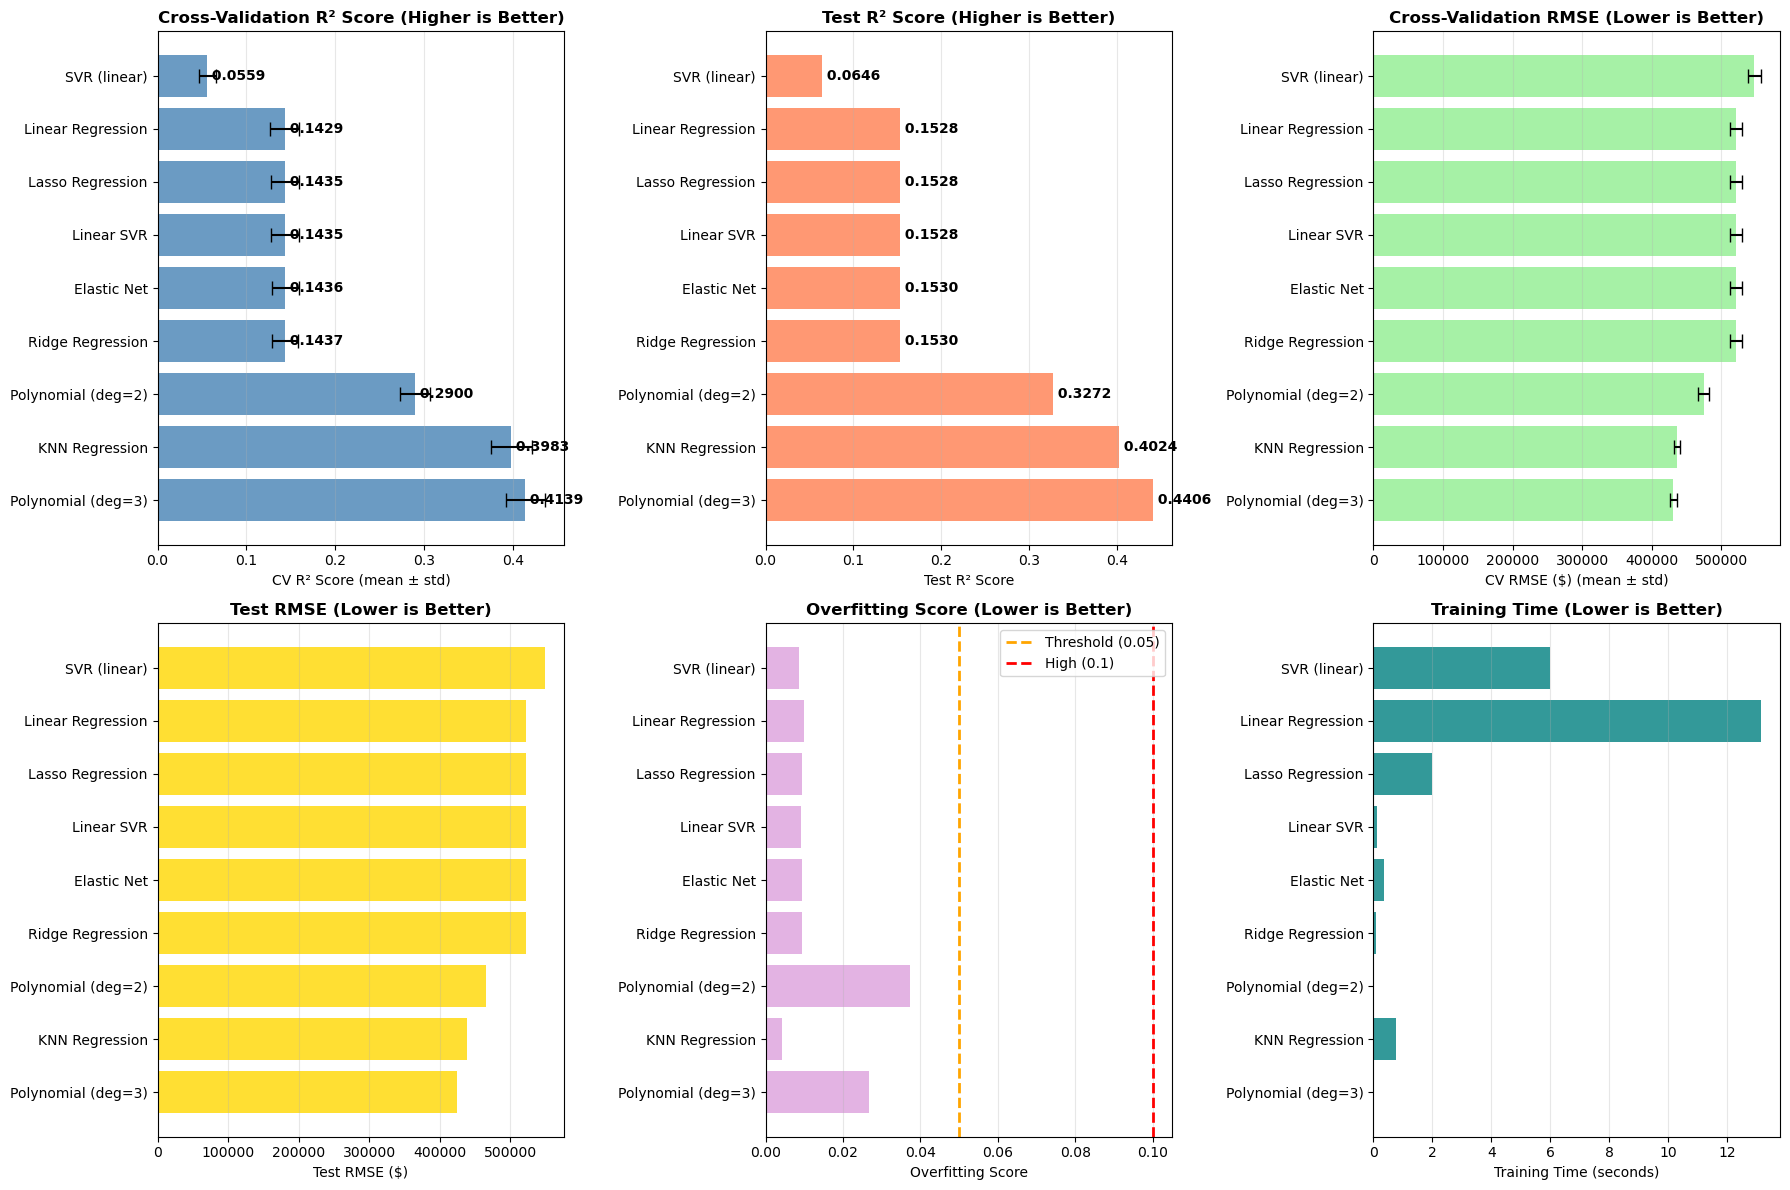

In [18]:
#  VISUALIZATION OF RESULTS
# 1. Model Comparison with CV scores
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# CV R² Score Comparison with error bars
axes[0, 0].barh(comparison_df['Model'], comparison_df['CV_R2_Mean'], 
                xerr=comparison_df['CV_R2_Std'], color='steelblue', alpha=0.8, capsize=5)
axes[0, 0].set_xlabel('CV R² Score (mean ± std)')
axes[0, 0].set_title('Cross-Validation R² Score (Higher is Better)', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['CV_R2_Mean']):
    axes[0, 0].text(v, i, f' {v:.4f}', va='center', fontweight='bold')

# Test R² Score Comparison
axes[0, 1].barh(comparison_df['Model'], comparison_df['Test_R2'], color='coral', alpha=0.8)
axes[0, 1].set_xlabel('Test R² Score')
axes[0, 1].set_title('Test R² Score (Higher is Better)', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['Test_R2']):
    axes[0, 1].text(v, i, f' {v:.4f}', va='center', fontweight='bold')

# CV RMSE Comparison with error bars
axes[0, 2].barh(comparison_df['Model'], comparison_df['CV_RMSE_Mean'], 
                xerr=comparison_df['CV_RMSE_Std'], color='lightgreen', alpha=0.8, capsize=5)
axes[0, 2].set_xlabel('CV RMSE ($) (mean ± std)')
axes[0, 2].set_title('Cross-Validation RMSE (Lower is Better)', fontweight='bold')
axes[0, 2].grid(axis='x', alpha=0.3)

# Test RMSE Comparison
axes[1, 0].barh(comparison_df['Model'], comparison_df['Test_RMSE'], color='gold', alpha=0.8)
axes[1, 0].set_xlabel('Test RMSE ($)')
axes[1, 0].set_title('Test RMSE (Lower is Better)', fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Overfitting Score
axes[1, 1].barh(comparison_df['Model'], comparison_df['Overfitting'], color='plum', alpha=0.8)
axes[1, 1].set_xlabel('Overfitting Score')
axes[1, 1].set_title('Overfitting Score (Lower is Better)', fontweight='bold')
axes[1, 1].axvline(x=0.05, color='orange', linestyle='--', linewidth=2, label='Threshold (0.05)')
axes[1, 1].axvline(x=0.1, color='red', linestyle='--', linewidth=2, label='High (0.1)')
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

# Training Time
axes[1, 2].barh(comparison_df['Model'], comparison_df['Training_Time'], color='teal', alpha=0.8)
axes[1, 2].set_xlabel('Training Time (seconds)')
axes[1, 2].set_title('Training Time (Lower is Better)', fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_with_cv.png', dpi=300, bbox_inches='tight')
print("✓ Saved: model_comparison_with_cv.png")
plt.show()

✓ Saved: cv_score_distribution.png


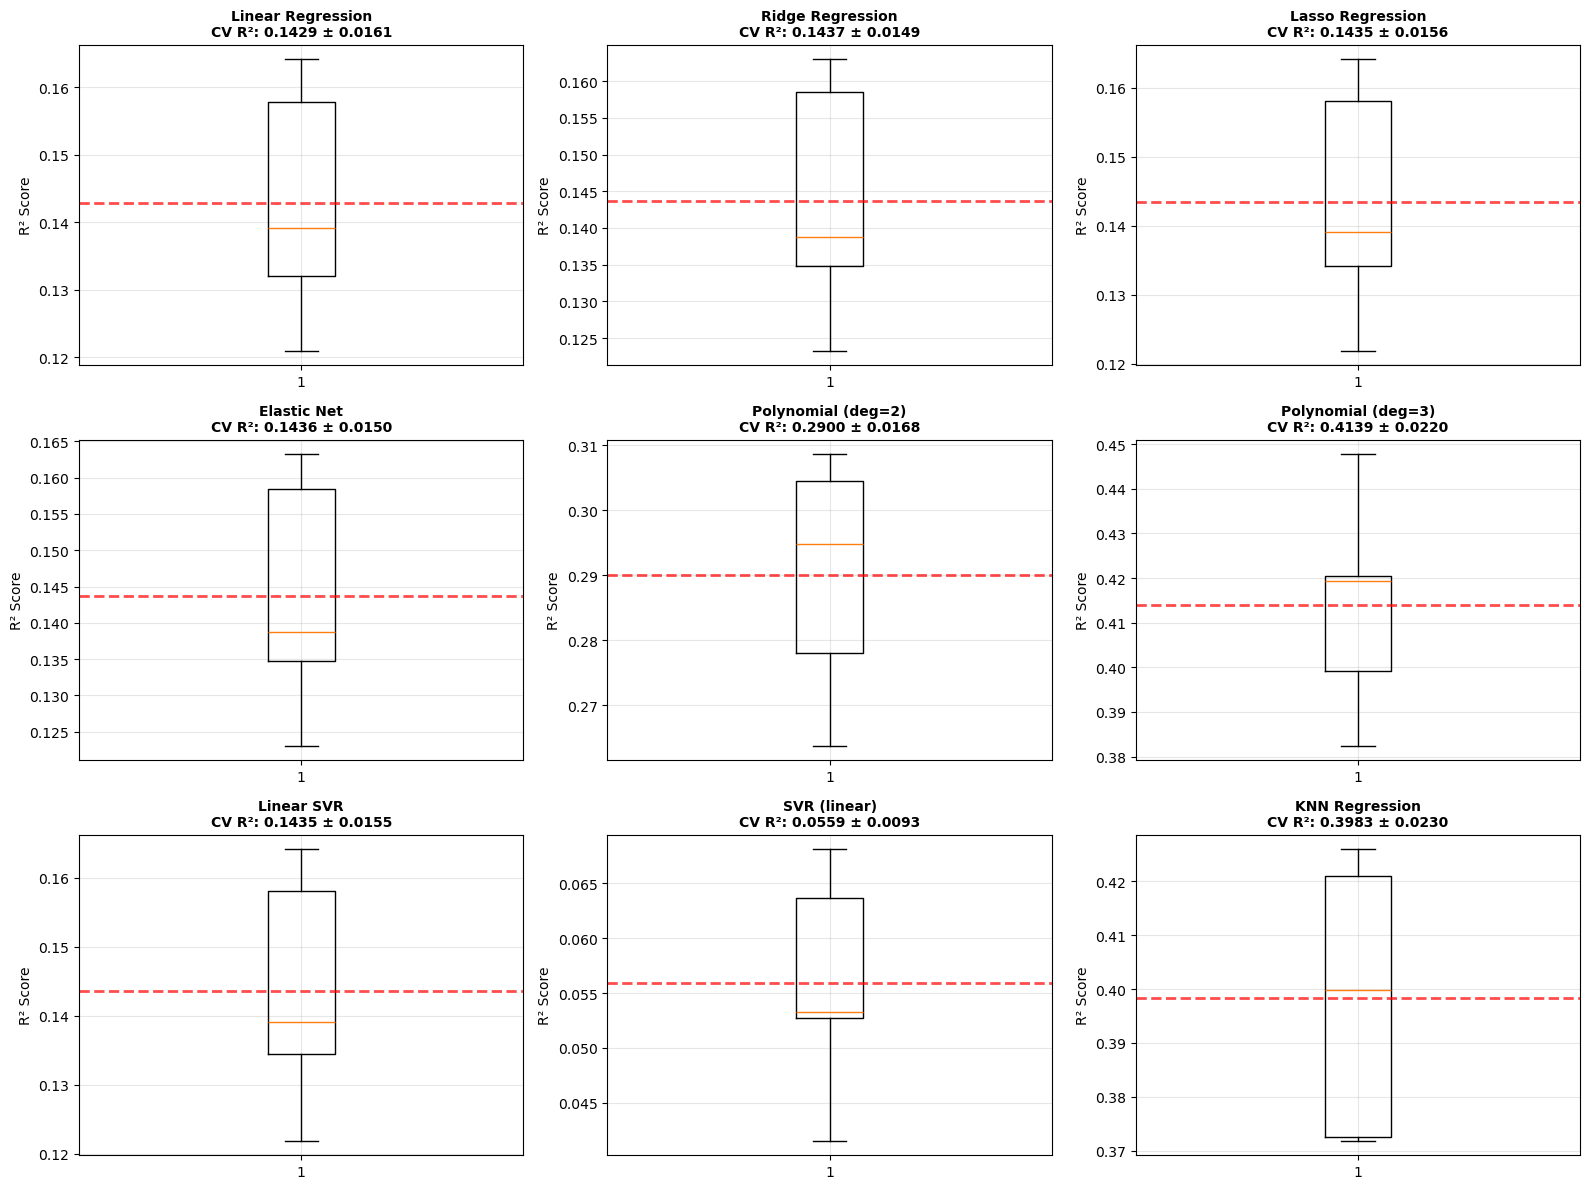

In [19]:
# 2. Cross-Validation Score Distribution
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, (model_name, model_data) in enumerate(results.items()):
    if idx >= 9:
        break
    cv_scores = model_data['cv_scores']
    axes[idx].boxplot(cv_scores, vert=True)
    axes[idx].set_title(f'{model_name}\nCV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}', 
                       fontweight='bold', fontsize=10)
    axes[idx].set_ylabel('R² Score')
    axes[idx].grid(alpha=0.3)
    axes[idx].axhline(y=cv_scores.mean(), color='r', linestyle='--', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.savefig('cv_score_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: cv_score_distribution.png")
plt.show()

✓ Saved: best_model_analysis.png


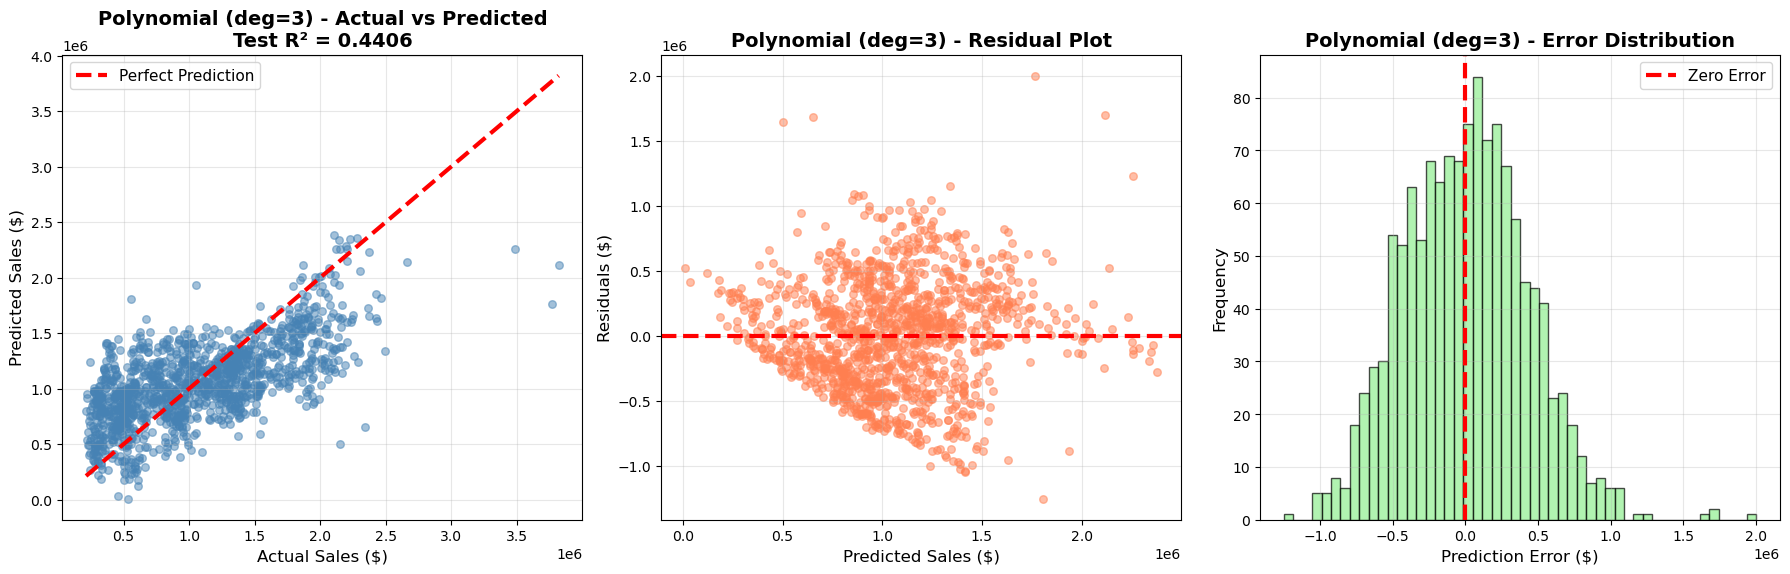

In [20]:
# 3. Actual vs Predicted for Best Model
best_predictions = results[best_model_name]['predictions']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot
axes[0].scatter(y_test, best_predictions, alpha=0.5, s=30, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=3, label='Perfect Prediction')
axes[0].set_xlabel('Actual Sales ($)', fontsize=12)
axes[0].set_ylabel('Predicted Sales ($)', fontsize=12)
axes[0].set_title(f'{best_model_name} - Actual vs Predicted\nTest R² = {best_model_test_r2:.4f}', 
                 fontweight='bold', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.5, s=30, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=3)
axes[1].set_xlabel('Predicted Sales ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title(f'{best_model_name} - Residual Plot', fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3)

# Residual distribution
axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[2].axvline(x=0, color='r', linestyle='--', linewidth=3, label='Zero Error')
axes[2].set_xlabel('Prediction Error ($)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title(f'{best_model_name} - Error Distribution', fontweight='bold', fontsize=14)
axes[2].legend(fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: best_model_analysis.png")
plt.show()

✓ Saved: train_vs_test_performance.png


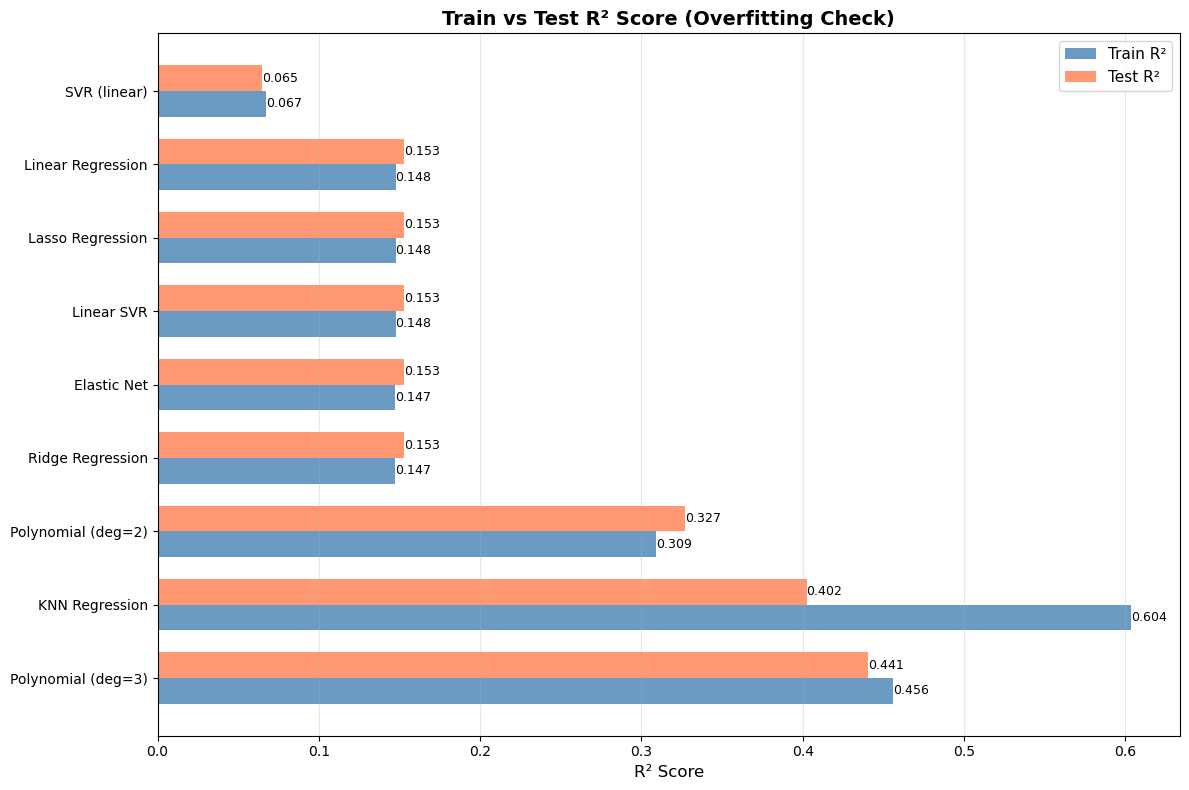

In [21]:
# 4. Train vs Test Performance
train_r2 = comparison_df['Train_R2'].values
test_r2 = comparison_df['Test_R2'].values
models = comparison_df['Model'].values

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(models))
width = 0.35

bars1 = ax.barh(x - width/2, train_r2, width, label='Train R²', color='steelblue', alpha=0.8)
bars2 = ax.barh(x + width/2, test_r2, width, label='Test R²', color='coral', alpha=0.8)

ax.set_xlabel('R² Score', fontsize=12)
ax.set_title('Train vs Test R² Score (Overfitting Check)', fontweight='bold', fontsize=14)
ax.set_yticks(x)
ax.set_yticklabels(models)
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)

for i, (train, test) in enumerate(zip(train_r2, test_r2)):
    ax.text(train, i - width/2, f'{train:.3f}', va='center', ha='left', fontsize=9)
    ax.text(test, i + width/2, f'{test:.3f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.savefig('train_vs_test_performance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: train_vs_test_performance.png")
plt.show()

✓ Saved: hyperparameter_tuning.png


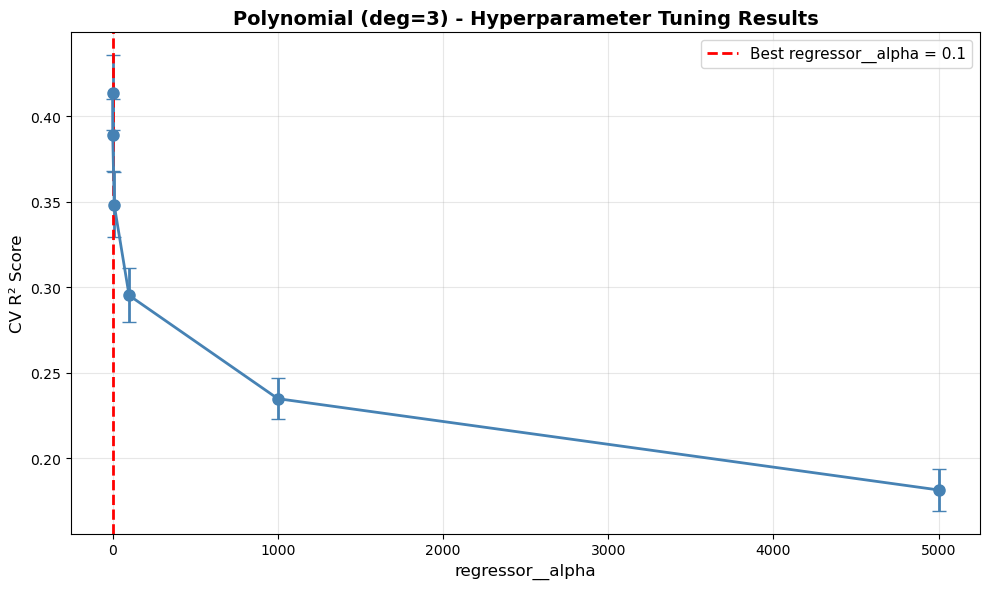

In [22]:
# 5. Hyperparameter Tuning Results (for best model with grid search)
if 'grid_results' in results[best_model_name]:
    grid_results = results[best_model_name]['grid_results']
    
    # Get parameter name (first parameter in grid search)
    param_name = list(results[best_model_name]['best_params'].keys())[0]
    
    if param_name in grid_results['params'][0]:
        param_values = [p[param_name] for p in grid_results['params']]
        mean_scores = grid_results['mean_test_score']
        std_scores = grid_results['std_test_score']
        
        # Remove duplicates if multiple parameters were tuned
        unique_params = sorted(set(param_values))
        if len(unique_params) < len(param_values):
            # Average scores for each unique parameter value
            avg_scores = []
            avg_stds = []
            for param in unique_params:
                indices = [i for i, p in enumerate(param_values) if p == param]
                avg_scores.append(np.mean([mean_scores[i] for i in indices]))
                avg_stds.append(np.mean([std_scores[i] for i in indices]))
            param_values = unique_params
            mean_scores = avg_scores
            std_scores = avg_stds
        
        plt.figure(figsize=(10, 6))
        plt.errorbar(param_values, mean_scores, yerr=std_scores, 
                    marker='o', markersize=8, capsize=5, linewidth=2, color='steelblue')
        plt.xlabel(param_name, fontsize=12)
        plt.ylabel('CV R² Score', fontsize=12)
        plt.title(f'{best_model_name} - Hyperparameter Tuning Results', fontweight='bold', fontsize=14)
        plt.grid(alpha=0.3)
        plt.xscale('log' if param_name in ['alpha', 'C'] else 'linear')
        
        # Mark best parameter
        best_param_value = results[best_model_name]['best_params'][param_name]
        best_score_idx = param_values.index(best_param_value) if best_param_value in param_values else 0
        plt.axvline(x=best_param_value, color='r', linestyle='--', linewidth=2, 
                   label=f'Best {param_name} = {best_param_value}')
        plt.legend(fontsize=11)
        
        plt.tight_layout()
        plt.savefig('hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: hyperparameter_tuning.png")
        plt.show()

In [23]:
# SAVE THE BEST MODEL AND RESULTS

best_model_obj = results[best_model_name]['model']
joblib.dump(best_model_obj, 'best_model_cv.pkl')
print(f"✓ Saved best model: best_model_cv.pkl ({best_model_name})")

# Save the scaler
joblib.dump(scaler, 'scaler_cv.pkl')
print("✓ Saved scaler: scaler_cv.pkl")

# Save model comparison results
comparison_df.to_csv('model_comparison_cv_results.csv', index=False)
print("✓ Saved comparison results: model_comparison_cv_results.csv")

# Save detailed results for each model
detailed_results = []
for model_name, model_data in results.items():
    result_dict = {
        'Model': model_name,
        'Best_Params': str(model_data['best_params']),
        **model_data['metrics']
    }
    detailed_results.append(result_dict)

detailed_df = pd.DataFrame(detailed_results)
detailed_df.to_csv('detailed_model_results.csv', index=False)
print("✓ Saved detailed results: detailed_model_results.csv")

# Save feature names and model info
feature_info = {
    'features': X.columns.tolist(),
    'best_model': best_model_name,
    'best_params': results[best_model_name]['best_params'],
    'cv_r2_mean': float(best_model_cv_r2),
    'cv_r2_std': float(comparison_df.iloc[0]['CV_R2_Std']),
    'test_r2': float(best_model_test_r2),
    'test_rmse': float(best_model_test_rmse),
    'cv_folds': CV_FOLDS,
    'train_size': int(len(X_train)),
    'test_size': int(len(X_test)),
    'overfitting_score': float(comparison_df.iloc[0]['Overfitting'])
}

import json
with open('model_info_cv.json', 'w') as f:
    json.dump(feature_info, f, indent=4)
print("✓ Saved model info: model_info_cv.json")

# Save all models (optional - for comparison later)
joblib.dump(results, 'all_models_cv.pkl')
print("✓ Saved all models: all_models_cv.pkl")

✓ Saved best model: best_model_cv.pkl (Polynomial (deg=3))
✓ Saved scaler: scaler_cv.pkl
✓ Saved comparison results: model_comparison_cv_results.csv
✓ Saved detailed results: detailed_model_results.csv
✓ Saved model info: model_info_cv.json
✓ Saved all models: all_models_cv.pkl
